In [1]:
from pytorch_tabnet.tab_model import TabNetRegressor

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import pandas as pd
import numpy as np
np.random.seed(0)


import os
import wget
from pathlib import Path


%load_ext autoreload

%autoreload 2

# Download census-income dataset

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
dataset_name = 'census-income'
out = Path(os.getcwd()+'/data/'+dataset_name+'.csv')

In [3]:
out.parent.mkdir(parents=True, exist_ok=True)
if out.exists():
    print("File already exists.")
else:
    print("Downloading file...")
    wget.download(url, out.as_posix())

File already exists.


# Load data and split

In [4]:
train = pd.read_csv(out)
target = ' <=50K'
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index
test_indices = train[train.Set=="test"].index

In [5]:
print(train_indices)

Int64Index([    0,     1,     2,     3,     4,     5,     6,     9,    10,
               11,
            ...
            32547, 32549, 32550, 32551, 32553, 32554, 32555, 32557, 32558,
            32559],
           dtype='int64', length=26072)


# Simple preprocessing

In [6]:
train.dtypes

39                 int64
 State-gov        object
 77516             int64
 Bachelors        object
 13                int64
 Never-married    object
 Adm-clerical     object
 Not-in-family    object
 White            object
 Male             object
 2174              int64
 0                 int64
 40                int64
 United-States    object
 <=50K            object
Set               object
dtype: object

In [7]:
train.head()

,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,Set
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,train
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,train
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,train
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,train
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K,train


In [8]:
# Label encode categorical features and fill empty cells.

categorical_columns = []
categorical_dims =  {}
for col in train.columns[train.dtypes == object]:
    print(col, train[col].nunique())
    l_enc = LabelEncoder()  # 문자를 정수형 자료로 변환시켜주는 인코더(수치화)
    train[col] = train[col].fillna("VV_likely") # 결측값 채우기 해당 값은 최빈값인가?
    train[col] = l_enc.fit_transform(train[col].values)
    categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)
    print(categorical_columns, categorical_dims[col])

# nunique 값이 작은 변수들을 categorical 변수로 등록 - one-hot encoding

for col in train.columns[train.dtypes == 'float64']:
    train.fillna(train.loc[train_indices, col].mean(), inplace=True)

 State-gov 9
[' State-gov'] 9
 Bachelors 16
[' State-gov', ' Bachelors'] 16
 Never-married 7
[' State-gov', ' Bachelors', ' Never-married'] 7
 Adm-clerical 15
[' State-gov', ' Bachelors', ' Never-married', ' Adm-clerical'] 15
 Not-in-family 6
[' State-gov', ' Bachelors', ' Never-married', ' Adm-clerical', ' Not-in-family'] 6
 White 5
[' State-gov', ' Bachelors', ' Never-married', ' Adm-clerical', ' Not-in-family', ' White'] 5
 Male 2
[' State-gov', ' Bachelors', ' Never-married', ' Adm-clerical', ' Not-in-family', ' White', ' Male'] 2
 United-States 42
[' State-gov', ' Bachelors', ' Never-married', ' Adm-clerical', ' Not-in-family', ' White', ' Male', ' United-States'] 42
 <=50K 2
[' State-gov', ' Bachelors', ' Never-married', ' Adm-clerical', ' Not-in-family', ' White', ' Male', ' United-States', ' <=50K'] 2
Set 3
[' State-gov', ' Bachelors', ' Never-married', ' Adm-clerical', ' Not-in-family', ' White', ' Male', ' United-States', ' <=50K', 'Set'] 3


# Define categorical features for categorical embeddings

In [9]:
unused_feat = ['Set']

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

# define your embedding sizes : here just a random choice (Optional)
cat_emb_dim = [5, 4, 3, 6, 2, 2, 1, 10]

# Network parameters

In [10]:
clf = TabNetRegressor(cat_dims=cat_dims, cat_emb_dim=cat_emb_dim, cat_idxs=cat_idxs)

/opt/conda/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [11]:
print(features)

['39', ' State-gov', ' 77516', ' Bachelors', ' 13', ' Never-married', ' Adm-clerical', ' Not-in-family', ' White', ' Male', ' 2174', ' 0', ' 40', ' United-States']


In [12]:
train.head()

,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,Set
0,50,6,83311,9,13,2,4,0,4,1,0,0,13,39,0,1
1,38,4,215646,11,9,0,6,1,4,1,0,0,40,39,0,1
2,53,4,234721,1,7,2,6,0,2,1,0,0,40,39,0,1
3,28,4,338409,9,13,2,10,5,2,0,0,0,40,5,0,1
4,37,4,284582,12,14,2,4,5,4,0,0,0,40,39,0,1


# Training

In [26]:
# X와 y의 형태 맞춰주기 -> n_tragets 값은 변경 가능
n_targets = 1

X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]
y_train = np.transpose(np.tile(y_train, (n_targets,1)))

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]
y_valid = np.transpose(np.tile(y_valid, (n_targets,1)))

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]
y_test = np.transpose(np.tile(y_test, (n_targets,1)))

In [27]:
print(X_train.shape, y_train.shape)

(26072, 14) (26072, 1)


In [28]:
max_epochs = 1000 if not os.getenv("CI", False) else 2

In [30]:
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['rmse'], #['rmsle', 'mae', 'rmse', 'mse']
    max_epochs=max_epochs,
    patience=50,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

epoch 0  | loss: 0.17564 | train_rmse: 0.54852 | valid_rmse: 0.54368 |  0:00:02s
epoch 1  | loss: 0.13847 | train_rmse: 0.43974 | valid_rmse: 0.43278 |  0:00:05s
epoch 2  | loss: 0.1285  | train_rmse: 0.39044 | valid_rmse: 0.38876 |  0:00:08s
epoch 3  | loss: 0.1232  | train_rmse: 0.38782 | valid_rmse: 0.38541 |  0:00:10s
epoch 4  | loss: 0.11749 | train_rmse: 0.40303 | valid_rmse: 0.40061 |  0:00:13s
epoch 5  | loss: 0.11647 | train_rmse: 0.36837 | valid_rmse: 0.36475 |  0:00:16s
epoch 6  | loss: 0.11363 | train_rmse: 0.3442  | valid_rmse: 0.34081 |  0:00:19s
epoch 7  | loss: 0.11246 | train_rmse: 0.33843 | valid_rmse: 0.33716 |  0:00:21s
epoch 8  | loss: 0.11184 | train_rmse: 0.33959 | valid_rmse: 0.3381  |  0:00:24s
epoch 9  | loss: 0.11043 | train_rmse: 0.33137 | valid_rmse: 0.32891 |  0:00:27s
epoch 10 | loss: 0.10892 | train_rmse: 0.32777 | valid_rmse: 0.32636 |  0:00:29s
epoch 11 | loss: 0.10937 | train_rmse: 0.32856 | valid_rmse: 0.32436 |  0:00:32s
epoch 12 | loss: 0.10884 | t

/opt/conda/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [31]:
preds = clf.predict(X_test)

test_rmse = mean_squared_error(y_pred=preds, y_true=y_test)**0.5

print(f"BEST VALID SCORE FOR {dataset_name} : {clf.best_cost}")
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_rmse}")

BEST VALID SCORE FOR census-income : 0.3080251202721779
FINAL TEST SCORE FOR census-income : 0.3184409838608684


# Global explainability : feat importance summing to 1

In [32]:
clf.feature_importances_

array([4.48931387e-02, 2.31856868e-01, 0.00000000e+00, 6.34769663e-02,
       6.84839537e-03, 1.32974592e-01, 1.05265706e-01, 8.16312128e-06,
       2.56215246e-02, 6.94263963e-02, 2.30727214e-01, 1.53338828e-02,
       4.59705731e-02, 2.75965789e-02])

In [36]:
clf.feature_importances_.shape

(14,)

# Local explainability and masks

In [33]:
explain_matrix, masks = clf.explain(X_test)

In [34]:
from matplotlib import pyplot as plt
%matplotlib inline

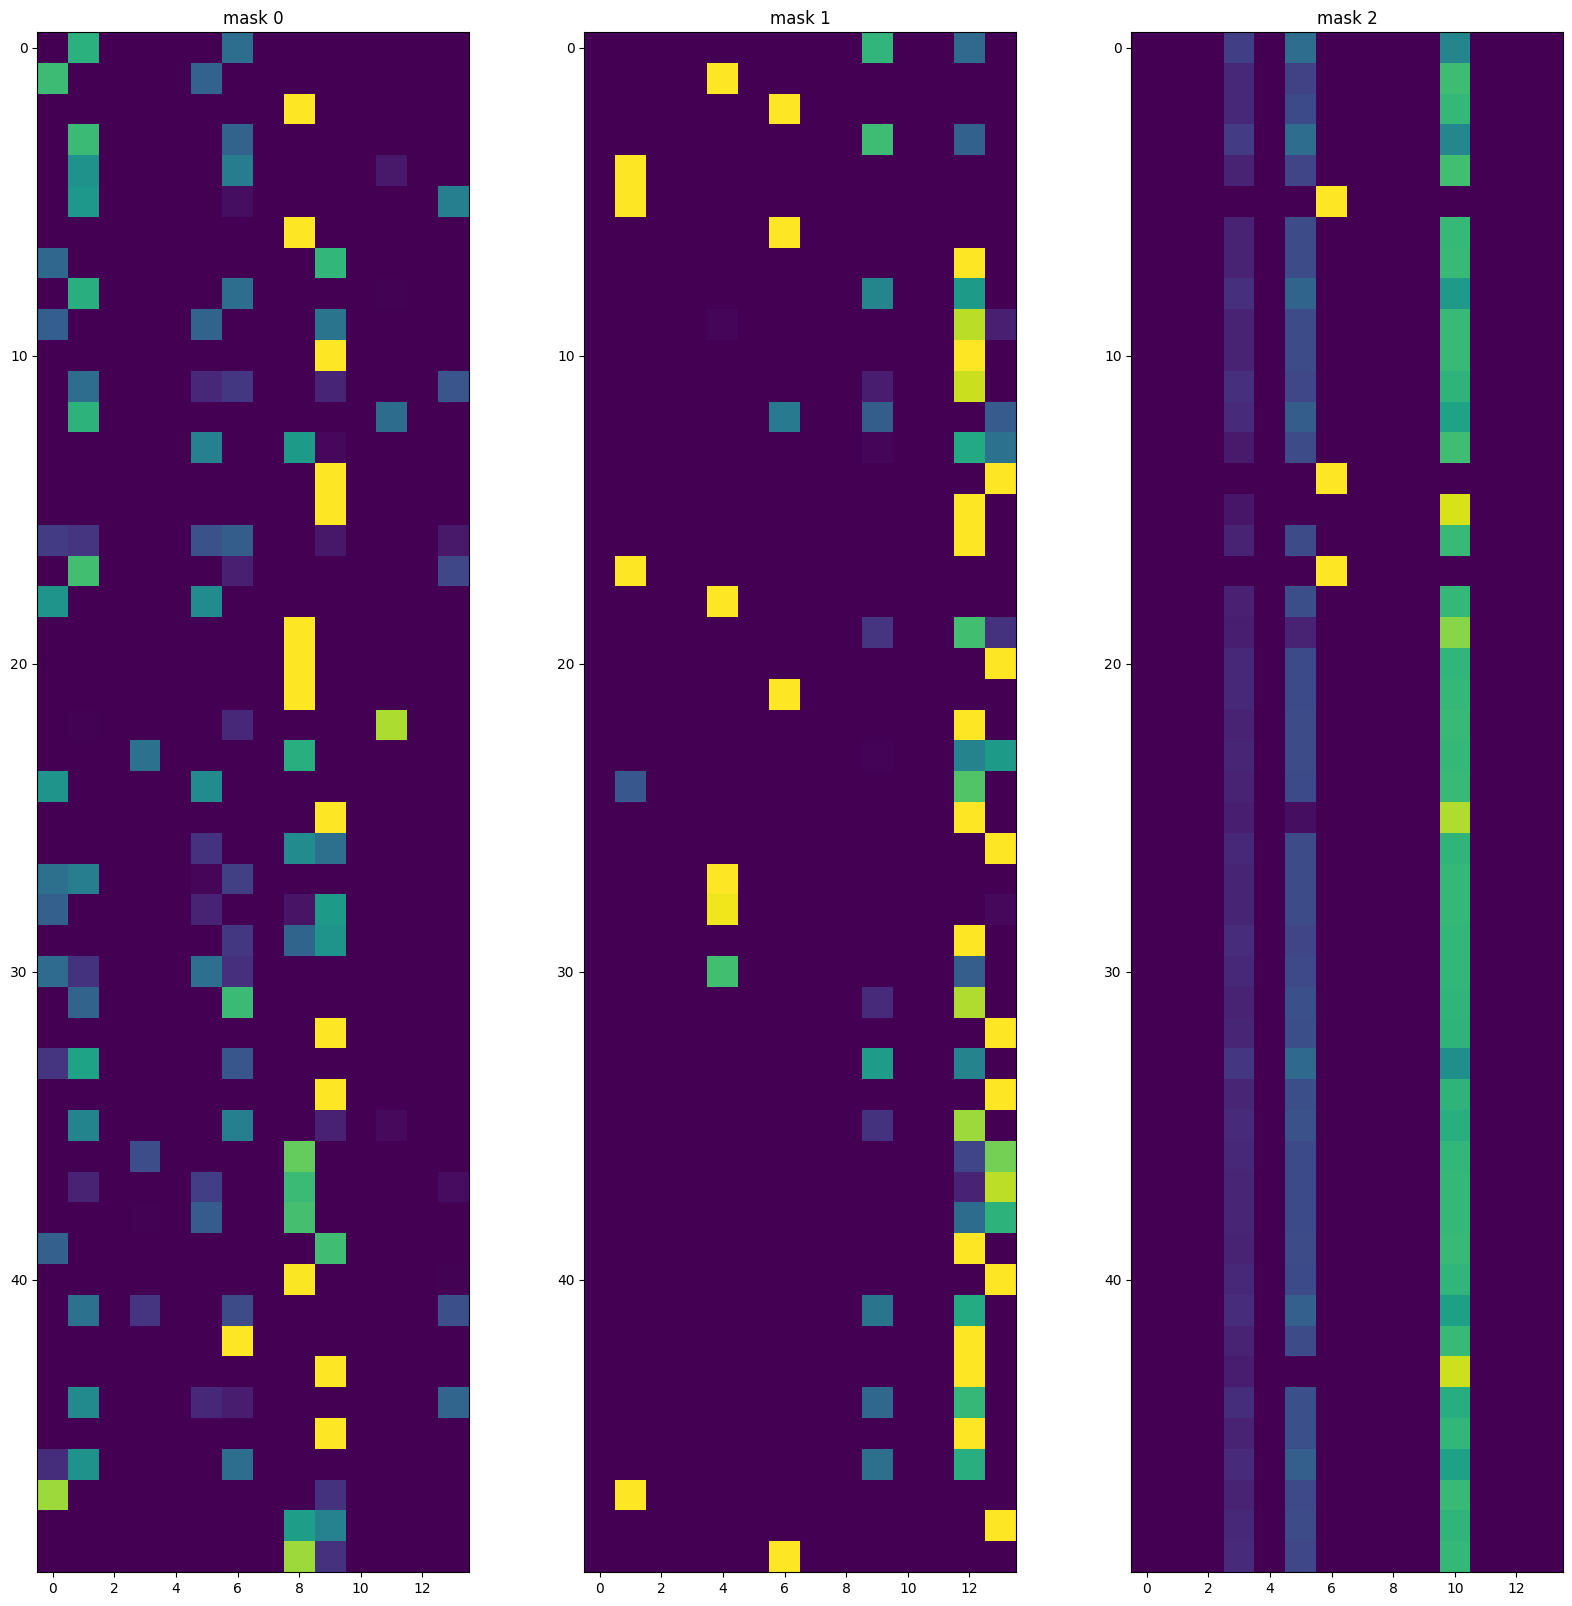

In [35]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")